# Elise's model runs
Nutrient comparisons with edited dataset using surface instead of 2m for depth. (

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools, nc_tools
import pytz
import os
import glob
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Change path, start and end dats here

In [24]:
PATH= '/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_KhT/'
start_date = datetime.datetime(2015,2,6, tzinfo = pytz.utc)
end_date = datetime.datetime(2015,8,4, tzinfo = pytz.utc)

In [4]:
#load model grid stuff
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [5]:
# Load CitSci data and clean it up
nutrients_2015 = pd.read_csv(
    '/ocean/eolson/MEOPAR/obs/PSFCitSci/PSFbottledata2015_CN_edits_EOCor2.csv')
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])
nutrients_2015 = nutrients_2015.dropna(subset=['Xind'])
nutrients_2015 = nutrients_2015[~nutrients_2015.flagged]
nutrients_2015 = nutrients_2015.dropna(subset=['Time'])

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [6]:
shape = nutrients_2015.shape[0]

In [9]:
local = pytz.timezone ("America/Los_Angeles")

In [10]:
bounds = np.array([start_date + datetime.timedelta(days = n*10) for n in range(19) ])
bounds[-1]

datetime.datetime(2015, 8, 5, 0, 0)

In [11]:
for n in range(19):
    bounds[n] = bounds[n].replace(tzinfo = pytz.utc)

In [12]:
bounds_r = (bounds - datetime.timedelta(days = 1))[1:]
bounds_l = bounds[:-1]

In [13]:
for n in range(18):
    bounds_l[n] = bounds_l[n].replace(tzinfo = pytz.utc)
for n in range(18):
    bounds_r[n] = bounds_r[n].replace(tzinfo = pytz.utc)

In [14]:
for n in range(18):
    bounds_l[n] = bounds_l[n].replace(minute = 30)
for n in range(18):
    bounds_r[n] = bounds_r[n].replace(hour = 23, minute = 30)

In [22]:
dates_utc = np.array([])
for n in nutrients_2015.index:
    date = (local.localize(pd.to_datetime(datetime.datetime.strptime(nutrients_2015['date'][n] 
                           +' '+ nutrients_2015['Time'][n], 
                           '%d-%m-%Y %I:%M:%S %p')), 
                   is_dst=True).astimezone(pytz.utc))
    dates_utc = np.append(dates_utc, date)

In [25]:
dates_utc = np.ma.masked_outside(dates_utc, start_date, end_date)

In [26]:
np.ma.count(dates_utc)

696

In [27]:
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates_utc.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates_utc.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates_utc.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates_utc.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates_utc.mask)
stations = np.ma.masked_array(nutrients_2015['station'].values, mask = dates_utc.mask)

In [36]:
list_of_model_si = np.ma.masked_array(np.zeros((shape)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((shape)), mask = True)
list_of_latitude = np.ma.masked_array(np.zeros((shape)), mask = True)
list_of_longitude = np.ma.masked_array(np.zeros((shape)), mask = True)
list_of_days = np.ma.masked_array(np.empty(shape, dtype='datetime64[s]'), mask = True)
t = 0
for n in nutrients_2015.index:
    if dates_utc.mask[t] == False:
        Yind = Yinds[t]
        Xind = Xinds[t]
        date = dates_utc[t]
        for m in range(18):
            if (date > bounds[m]) & (date < bounds[m+1]):
                here = m
        datestr_l = bounds_l[here].strftime('%Y%m%d')
        datestr_r = bounds_r[here].strftime('%Y%m%d')
        datestr = datestr_l + '-' + datestr_r
        nuts = nc.Dataset(glob.glob(PATH + 'SalishSea*1h*ptrc_T*' + datestr +'.nc')[0])
        if nutrients_2015['depth'][n] == 2:
            depth = 0
        elif nutrients_2015['depth'][n] == 20:
            depth = 18
        if mesh.variables['tmask'][0,depth,Yind,Xind] == 1:
            if date.minute < 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            if date.minute >= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
            before = before.replace(tzinfo = pytz.utc)
            delta = (date.minute) / 60
            hour = (before - bounds_l[here]).days * 24 + int((before - bounds_l[here]).seconds / 60 / 60)
            if hour > 238:
                datestr_lb = bounds_l[here+1].strftime('%Y%m%d')
                datestr_rb = bounds_r[here+1].strftime('%Y%m%d')
                datestr2 = datestr_lb + '-' + datestr_rb
                nuts2 = nc.Dataset(glob.glob(PATH + 'SalishSea*1h*ptrc_T*' + datestr2 +'.nc')[0])
                ni_val = (delta*(nuts.variables['nitrate'][hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['nitrate'][0, depth, Yind, Xind] ))
                si_val = (delta*(nuts.variables['silicon'][hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['silicon'][0, depth, Yind, Xind] ))
            else:
                ni_val = (delta*(nuts.variables['nitrate'][hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts.variables['nitrate'][hour+1, depth, Yind, Xind] ))
                si_val = (delta*(nuts.variables['silicon'][hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts.variables['silicon'][hour+1, depth, Yind, Xind] ))
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = si_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = ni_val
            list_of_latitude.mask[t] = False
            list_of_latitude[t] = nutrients_2015['lat'][n]
            list_of_longitude.mask[t] = False
            list_of_longitude[t] = nutrients_2015['lon'][n]
            list_of_days.mask[t] = False
            list_of_days[t] = date
    t = t + 1

In [37]:
cs_no23.mask = list_of_model_ni.mask
cs_si.mask = list_of_model_si.mask

In [38]:
stations = np.ma.masked_array(stations, mask = list_of_model_si.mask)

In [39]:
np.ma.count(cs_no23)

687

bias =  -0.614161180305997
RMSE = 5.807182736875049
Willmott = 0.8983856520387424


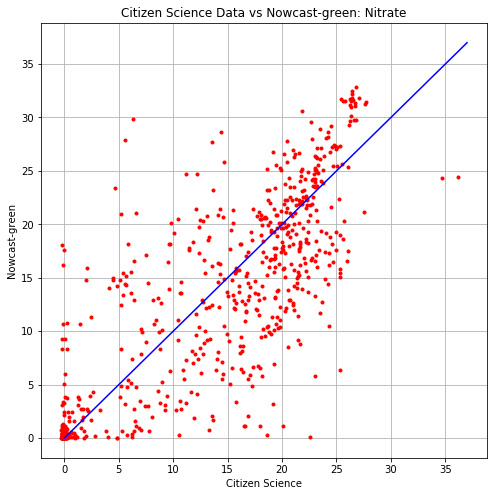

In [40]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_no23, list_of_model_ni, 'r.')
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_no23) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_no23)**2) /
                              np.ma.count(cs_no23))))
xbar = np.mean(cs_no23)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_no23)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_no23 - xbar))**2))))

bias =  -6.196472591201466
RMSE = 13.852656411875936
Willmott = 0.7919086251423371


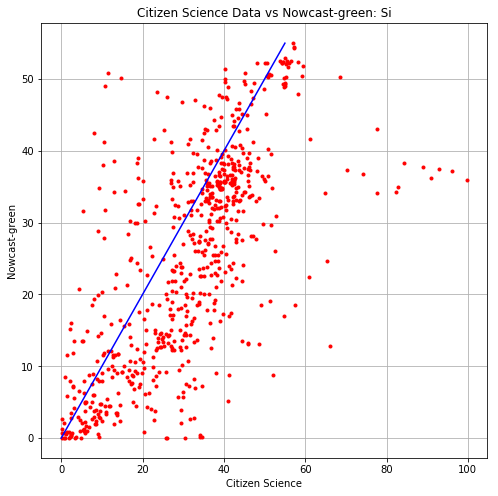

In [41]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              np.ma.count(cs_no23))))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

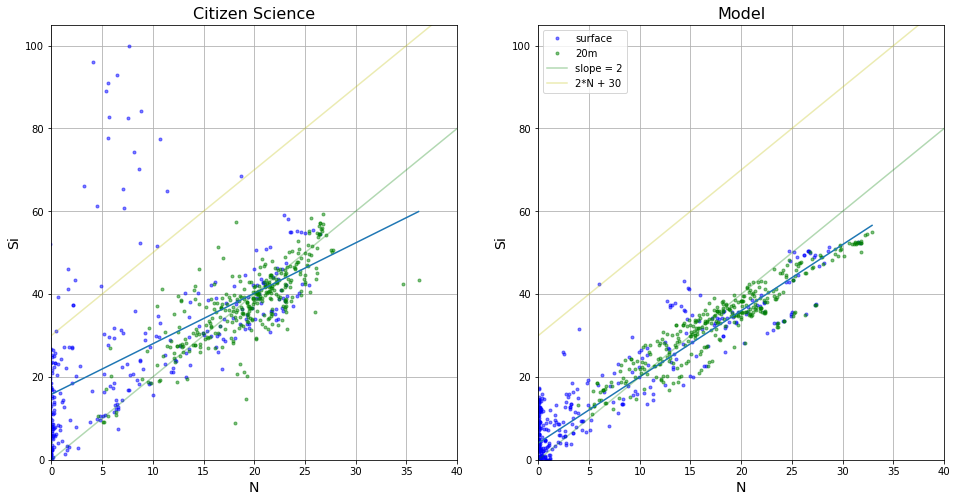

In [42]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_no23[nutrients_2015['depth'].values == 2], 
           cs_si[nutrients_2015['depth'].values == 2], 
           'b.', alpha = 0.5)
ax[0].plot(cs_no23[nutrients_2015['depth'].values == 20], 
           cs_si[nutrients_2015['depth'].values == 20], 
           'g.', alpha = 0.5)
ax[0].plot(np.unique(cs_no23), np.poly1d(np.polyfit(cs_no23, cs_si, 1))(np.unique(cs_no23)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 2], 
           list_of_model_si[nutrients_2015['depth'].values == 2], 'b.', 
           alpha = 0.5, label = 'surface')
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 20], 
           list_of_model_si[nutrients_2015['depth'].values == 20], 'g.', 
           alpha = 0.5, label = '20m')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [43]:
m1, b1 = np.polyfit(cs_no23, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.2187430117967932
CitSci y int = 15.815501339767406
model slope = 1.59720979886845
model y int = 4.059458279937223
